# Homework 5 - Improving the Pipeline, Again

CAPP 30235 Machine Learning for Public Policy

Jonathan Tan

May 30, 2019

# Part 1: Coding Assignment

Since I use most of the new functions prompted below in my analysis of the DonorsChoose data, I'll just briefly explain in this section which new functions I wrote and what they do.

### 1. Fix and improve the pipeline code you submitted for the last assignment based on the feedback from the TA. if something critical was pointed out in the feedback, you need to fix it. You'll get the last homework back by ends of thursday so you'll still have time before this one is due to address those comments.

I received no feedback from my last assignment, so I have skipped this step.

### 2. Add more classifiers to the pipeline. It should at least have Logistic Regression, K­Nearest Neighbor, Decision Trees, SVM, Random Forests, Boosting, and Bagging. The code should have a parameter for running one or more of these classifiers and your analysis should run all of them.

#### 2.1 `train_classifier()`

`train_classifier()` takes 2 pandas DataFrames (features and labels of training data) and the name of a classifier to fit. It optionally takes a nested dictionary of hyperparameters to use for each. (For this notebook, these parameters can be changed in the `pipeline_config.py` file.) It returns a trained classifier object.

### 3. Experiment with different parameters for these classifiers (different values of k for example, as well as parameters that other classifiers have). You should look at the sklearn documentation to see what parameter each classifier can take and what the default values sklearn selects. The labs should be helpful here.

Results of experimenting with different parameters (e.g. penalty and C for LogisticRegression, n_estimators for Boosting) can be seen in the parameter dictionary in the `pipeline_config.py` file. I looped over several ranges of reasonable values for each parameter and selected the configuration producing the largest AUC-ROC. These will be the default parameters used in the DonorsChoose analysis part of this assignment.

### 4. Add additional evaluation metrics that we've covered in class to the pipeline (accuracy, precision at different levels, recall at different levels, F1, area under curve, and precision-recall curves).

#### 4.1 `validate_classifier()`

`validate_classifier()` takes 2 dataframes (features and labels for test data) and a pre-trained classifier object as inputs, calculates several evaluation metrics (accuracy, precision, recall, F1, etc.) and returns a dictionary of those metrics.

### 5. Create temporal validation function in your pipeline that can create training and test sets over time. You can choose the length of these splits based on analyzing the data. For example, the test sets could be six months long and the training sets could be all the data before each test set.

#### 5.1 `split_data_temporal()`

`split_data_temporal()` takes a pandas DataFrame and specified label/date column names as inputs, then splits the dataframe on the specified timeframe. The default test set duration is the most recent 1 year of data. It returns two dataframes and two series in order:
 1. training features
 2. test features
 3. training labels
 4. test labels


# Part 2: Analysis

## 0. Setup

In [1]:
# Setup autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, scale

# Import pipeline library, hardcoded config file values
import pipeline_library as library
import pipeline_config as config

# Tweak display settings for tables
pd.options.display.max_columns = 999

## 1. Read data

In [3]:
DATE_COLS = ['date_posted', 'datefullyfunded']

df = pd.read_csv(config.DATA_PATH, parse_dates=DATE_COLS)
print(df.shape)
df.head()

(124976, 26)


,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,school_county,school_charter,school_magnet,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,Cook,f,f,Mrs.,Mathematics,Math & Science,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,2013-04-14,2013-05-02
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,Ventura,f,f,Mrs.,Civics & Government,History & Civics,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,t,2012-04-07,2012-04-18
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,Los Angeles,f,f,Ms.,Literacy,Literacy & Language,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,f,2012-01-30,2012-04-15
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,Kings (Brooklyn),f,t,Ms.,Literacy,Literacy & Language,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,f,2012-10-11,2012-12-05
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,Suffolk,f,f,Mrs.,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,f,2013-01-08,2013-03-25


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124976 entries, 0 to 124975
Data columns (total 26 columns):
projectid                                 124976 non-null object
teacher_acctid                            124976 non-null object
schoolid                                  124976 non-null object
school_ncesid                             115743 non-null float64
school_latitude                           124976 non-null float64
school_longitude                          124976 non-null float64
school_city                               124976 non-null object
school_state                              124976 non-null object
school_metro                              109752 non-null object
school_district                           124804 non-null object
school_county                             124976 non-null object
school_charter                            124976 non-null object
school_magnet                             124976 non-null object
teacher_prefix                           

## 2. Explore data

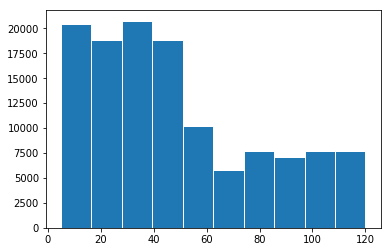

In [5]:
# Histogram of number of days to being fully funded
df['days_to_funded'] = (df['datefullyfunded'] - df['date_posted']).dt.days
df['days_to_funded'].hist(grid=False, edgecolor='white')

In [6]:
# What percentage of projects are not funded within 60 days?
len(df.loc[df['days_to_funded'] > 60]) / len(df)

0.2881353219818205

29% of projects were not funded within 60 days.

In [7]:
numeric_features = ['total_price_including_optional_support', 'students_reached']

library.describe_data(df, varlist=numeric_features)

,total_price_including_optional_support,students_reached
count,124976.000000,124917.000000
mean,654.011811,95.445760
std,1098.015854,163.481912
min,92.000000,1.000000
25%,345.810000,23.000000
50%,510.500000,30.000000
75%,752.960000,100.000000
max,164382.840000,12143.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d162eb8>]],
      dtype=object)

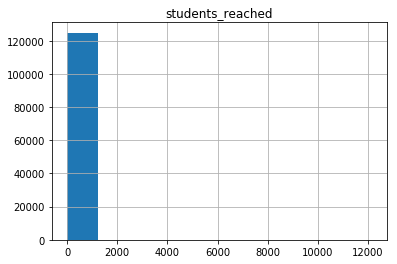

In [8]:
# A lot of 999 values and above - discretize and add a topcode 
df[['students_reached']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d30ec50>]],
      dtype=object)

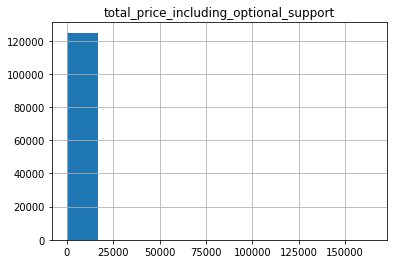

In [9]:
df[['total_price_including_optional_support']].hist()

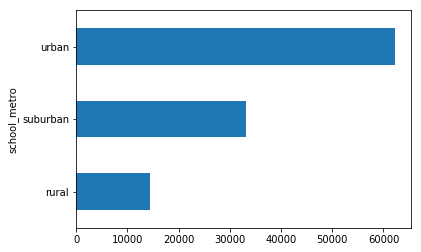

In [10]:
df[['school_metro']].groupby('school_metro').size().sort_values().plot.barh()

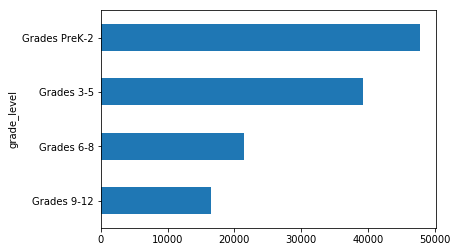

In [11]:
df[['grade_level']].groupby('grade_level').size().sort_values().plot.barh()

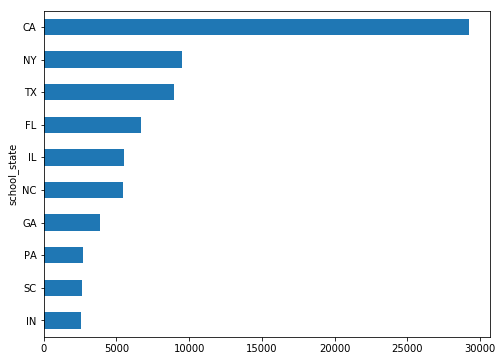

In [12]:
# Number of projects from the 10 largest states
df[['school_state']].groupby('school_state').size().sort_values().tail(10).plot.barh(figsize=(8, 6))

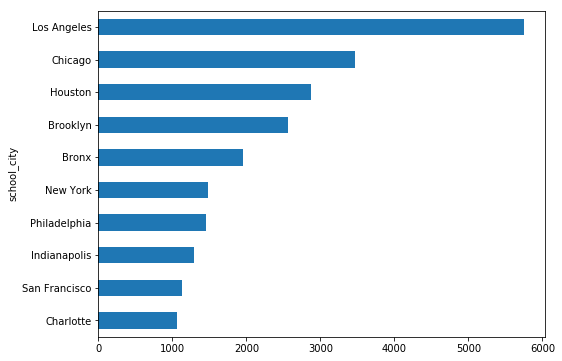

In [13]:
# Number of projects from the 10 largest cities
df[['school_city']].groupby('school_city').size().sort_values().tail(10).plot.barh(figsize=(8, 6))

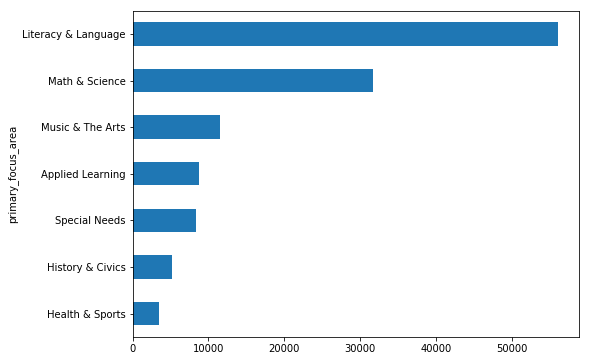

In [14]:
df[['primary_focus_area']].groupby('primary_focus_area').size().sort_values().plot.barh(figsize=(8, 6))

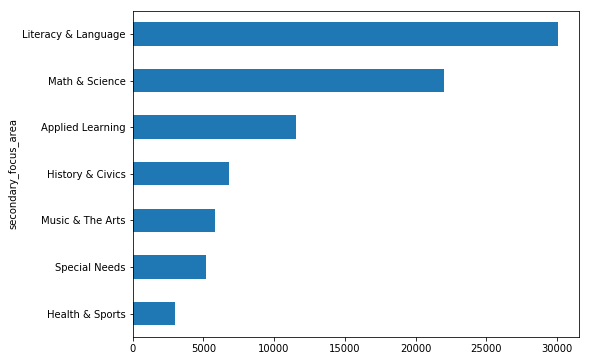

In [15]:
df[['secondary_focus_area']].groupby('secondary_focus_area').size().sort_values().plot.barh(figsize=(8, 6))

## 3 Preprocess data

1. Based on data exploration, select features to be cleaned up and used in the model
2. See what data is missing (for later imputation)

### 3.1 Select features for the final model(s)

Here, I've excluded extraneous features like the ID columns and lat/long data, as well as geographical features like `school_district` and `school_city` that should be highly collinear with the remaining `school_county` and `school_state` features. The remaining features are, as decribed by the [datasource](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data):

| Feature | Type | Description
| ---------- | ---------- | ----------
| `school_city` | categorical | City in which school is located
| `school_state` | categorical | State in which school is located
| `school_metro` | categorical | Rural, urban, or suburban
| `school_charter` | boolean | Is the school a public charter school?
| `school_magnet` | boolean | Is the school a public magnet school?
| `teacher_prefix` | categorical | Dr., Mr., Mrs., or Ms.
| `primary_focus_area`| categorical | Main subject area for which project materials are intended
| `secondary_focus_area` | categorical | Secondary subject area for which project materials are intended
| `resource_type` | categorical | Books, supplies, technology, etc.
| `poverty_level` | categorical | Low, moderate, high, highest
| `grade_level` | categorical | Grade level for which project materials are intended
| `total_price_including_optional_support` | categorical | Project cost including optional tip that donors give to DonorsChoose.org while funding a project 
| `students_reached` | numeric | Number of students impacted by a project (if funded)
| `eligible_double_your_impact_match` | boolean | Project was eligible for a 50% off offer by a corporate partner

In [16]:
selected_features = ['school_state', 'school_metro', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_area', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded']

df = df[selected_features]

### 3.2 Check missing data

In [17]:
missing = df.isnull().sum(axis=0).reset_index().rename({'index': 'feature', 0: 'num_missing'}, axis=1)

missing.loc[missing['num_missing'] > 0]

,feature,num_missing
1,school_metro,15224
5,primary_focus_area,15
6,secondary_focus_area,40556
7,resource_type,17
9,grade_level,3
11,students_reached,59


## 4. Split data into test and train sets by time

Per the instructions, "The data spans Jan 1, 2012 to Dec 31, 2013. You should have your validation/test set be a rolling window of 6 months (which should give you three test sets). The training sets should be everything from 1/1/12 to the beginning of the test set."

In [18]:
# Test durations are recorded in conflg.TEMPORAL_SPLITS, which is a list of dictionaries 
# that keep start and end dates for test sets as entries.

train_dfs = []
test_dfs = []

for i in config.TEMPORAL_SPLITS:
    train_dfs.append(df.loc[df['date_posted'] < pd.to_datetime(i['test_start'])])
    test_dfs.append(df.loc[(df['date_posted'] >= pd.to_datetime(i['test_start'])) &
                           (df['date_posted'] <= pd.to_datetime(i['test_end']))])

In [19]:
# Verify that train and test data were split properly
print("TRAINING DATA:")
for idx, i in enumerate(train_dfs):
    print(f"{idx+1} Start: {i['date_posted'].min().date()}, End: {i['date_posted'].max().date()}")
print("TEST DATA:")
for idx, j in enumerate(test_dfs):
    print(f"{idx+1} Start: {j['date_posted'].min().date()}, End: {j['date_posted'].max().date()}")

TRAINING DATA:
1 Start: 2012-01-01, End: 2012-06-30
2 Start: 2012-01-01, End: 2012-12-31
3 Start: 2012-01-01, End: 2013-06-30
TEST DATA:
1 Start: 2012-07-01, End: 2012-12-31
2 Start: 2013-01-01, End: 2013-06-30
3 Start: 2013-07-01, End: 2013-12-31


## 5. Data Cleaning, Feature Generation

To avoid pre-processing data that will be omitted from the training data, below I pre-select the features I want to use and focus on cleaning those.

Data cleaning steps:
1. Define label: `funded_in_60_days`
2. Clean missing data
3. Normalize numeric data
4. Make binary data into true binary
5. Make categorical data into dummies

### 5.1 Define label: `funded_in_60_days`

In [20]:
for df_list in (train_dfs, test_dfs):
    for df in df_list:
        
        # Label = 1 if datefullyfunded is more than 60 days after date_posted
        df['not_funded_60_days'] = \
            np.where(df['datefullyfunded'] - df['date_posted'] > pd.to_timedelta(60, unit='days'), 1, 0)
        
        # Leave a lag period of 60 days at the end of each dataset
        df = df.loc[df['date_posted'].max() - df['date_posted'] > pd.to_timedelta(60, unit='days')]

In [21]:
# Verify that label has been created correctly
train_dfs[0].head()

,school_state,school_metro,school_charter,school_magnet,teacher_prefix,primary_focus_area,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,not_funded_60_days
1,CA,urban,f,f,Mrs.,History & Civics,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,t,2012-04-07,2012-04-18,0
2,CA,urban,f,f,Ms.,Literacy & Language,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,f,2012-01-30,2012-04-15,1
16,KY,suburban,f,f,Ms.,Math & Science,Math & Science,Supplies,high poverty,Grades 6-8,481.18,120.0,f,2012-01-26,2012-05-17,1
18,CA,urban,f,f,Ms.,Literacy & Language,NaN,Books,highest poverty,Grades 3-5,296.68,30.0,t,2012-01-23,2012-02-20,0
23,CA,suburban,f,f,Mrs.,History & Civics,Special Needs,Technology,highest poverty,Grades PreK-2,2130.40,30.0,f,2012-04-29,2012-07-16,1


In [22]:
# Drop unnecessary columns
for df_list in (train_dfs, test_dfs):
    for i in range(len(df_list)):

        df_list[i] = df_list[i].drop(labels=['date_posted', 'datefullyfunded'], axis=1)

### 5.2 Clean missing data

For many categorical features, we have no reliable way of filling in the missing data with useful placeholders. I'll leave these as missing, and when the categorical variable is discretized into a series of binary feature later, all missing values will be indicated in their own binary feature.

For the numeric column with missing data - students reached - we will impute missing values with the median value of the feature, and add a binary feature indicating the value was imputed (this is done with `fill_missing()`).

In [23]:
missing.loc[missing['num_missing'] > 0]

,feature,num_missing
1,school_metro,15224
5,primary_focus_area,15
6,secondary_focus_area,40556
7,resource_type,17
9,grade_level,3
11,students_reached,59


In [24]:
for df_list in (train_dfs, test_dfs):
    for df in df_list:
        df = library.fill_missing(df, ['students_reached'], median=True)

### 4.4 Rescale/standardize numeric data

Rescale numeric features to mean 0, standard deviation 1.

In [25]:
for df_list in (train_dfs, test_dfs):
    for df in df_list:

        for i in numeric_features:
            df[i] = scale(df[i])
    
train_dfs[0][numeric_features].describe()

,total_price_including_optional_support,students_reached
count,2.638600e+04,2.638600e+04
mean,-9.023244e-18,1.717551e-16
std,1.000019e+00,1.000019e+00
min,-5.137497e-01,-5.434016e-01
25%,-2.645127e-01,-4.143174e-01
50%,-9.645843e-02,-3.651425e-01
75%,8.540535e-02,3.669342e-03
max,8.976072e+01,5.659170e+01


### 4.5 Make binary data into true binary format

The `school_charter`, `school_magnet` and `eligible_double_your_impact_match` features are also binary variables coded as string variables ("t" or "f"), so we'll convert them to a true binary variable.

In [26]:
binary_features = ['school_charter', 'school_magnet', 'eligible_double_your_impact_match']

train_dfs[0][binary_features].head()

,school_charter,school_magnet,eligible_double_your_impact_match
1,f,f,t
2,f,f,f
16,f,f,f
18,f,f,t
23,f,f,f


In [27]:
for df_list in (train_dfs, test_dfs):
    for df in df_list:
        
        for i in binary_features:
            df[i] = np.where(df[i] == 't', 1, 0)

train_dfs[0][binary_features].head()

,school_charter,school_magnet,eligible_double_your_impact_match
1,0,0,1
2,0,0,0
16,0,0,0
18,0,0,1
23,0,0,0


### 4.6 Make categorical data into dummies

For locational columns with high cardinality like `school_city` (4,276 unique values), I retain the values for the top 50 most frequent values (see Section 2 above) and bin all other city/state locations in "other". 

In [28]:
categorical_features = ['school_state', 'school_metro', 'teacher_prefix', \
                        'resource_type', 'primary_focus_area', 'secondary_focus_area', \
                        'poverty_level', 'grade_level']

for i in categorical_features:
    print(f'{i} has {df[i].unique().shape[0]} unique values')
    
train_dfs[0][categorical_features].head()

school_state has 51 unique values
school_metro has 4 unique values
teacher_prefix has 4 unique values
resource_type has 6 unique values
primary_focus_area has 7 unique values
secondary_focus_area has 8 unique values
poverty_level has 4 unique values
grade_level has 4 unique values


,school_state,school_metro,teacher_prefix,resource_type,primary_focus_area,secondary_focus_area,poverty_level,grade_level
1,CA,urban,Mrs.,Books,History & Civics,Literacy & Language,highest poverty,Grades 3-5
2,CA,urban,Ms.,Technology,Literacy & Language,History & Civics,high poverty,Grades 3-5
16,KY,suburban,Ms.,Supplies,Math & Science,Math & Science,high poverty,Grades 6-8
18,CA,urban,Ms.,Books,Literacy & Language,NaN,highest poverty,Grades 3-5
23,CA,suburban,Mrs.,Technology,History & Civics,Special Needs,highest poverty,Grades PreK-2


In [29]:
for df_list in (train_dfs, test_dfs):
    for i in range(len(df_list)):
        
        # Bin less-frequent cities as "Other"
#         most_freq_cities = df_list[i].groupby('school_city').size().sort_values(ascending=False).head(10).index.tolist()
#         df_list[i]['school_city'] = np.where(df_list[i]['school_city'].isin(most_freq_cities), df_list[i]['school_city'], "Other")
        
        # Make dummy variables for categorical features
        for j in categorical_features:
            df_list[i] = library.make_dummy_vars(df_list[i], j)

train_dfs[0].head()

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,not_funded_60_days,students_reached_imputed,school_state_AK,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,school_state_DC,school_state_DE,school_state_FL,school_state_GA,school_state_HI,school_state_IA,school_state_ID,school_state_IL,school_state_IN,school_state_KS,school_state_KY,school_state_LA,school_state_MA,school_state_MD,school_state_ME,school_state_MI,school_state_MN,school_state_MO,school_state_MS,school_state_MT,school_state_NC,school_state_ND,school_state_NE,school_state_NH,school_state_NJ,school_state_NM,school_state_NV,school_state_NY,school_state_OH,school_state_OK,school_state_OR,school_state_PA,school_state_RI,school_state_SC,school_state_SD,school_state_TN,school_state_TX,school_state_UT,school_state_VA,school_state_VT,school_state_WA,school_state_WI,school_state_WV,school_state_WY,school_metro_rural,school_metro_suburban,school_metro_urban,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2
1,0,0,-0.330764,-0.377436,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
2,0,0,0.440299,-0.205324,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
16,0,0,-0.120850,0.188075,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
18,0,0,-0.315752,-0.365143,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
23,0,0,1.621353,-0.365143,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1


In [30]:
# Final feature set
for df_list in (train_dfs, test_dfs):
    for df in df_list:
        print(df.shape)

(26386, 92)
(59224, 92)
(80809, 92)
(32838, 92)
(21585, 92)
(44167, 93)


In [31]:
set(test_dfs[2].columns.tolist()) - set(test_dfs[1].columns.tolist())
# Only the Dr. prefix appears in the last test set (7/1/2013 - 12/31/2013). This might be a problem.

{'teacher_prefix_Dr.'}

In [32]:
# Check if all train and test sets have any remaining missing values
for df_list in (train_dfs, test_dfs):
    for df in df_list:
        print(df.isnull().sum(axis=0).any())

False
False
False
False
False
False


In [33]:
# Final feature list
train_dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26386 entries, 1 to 124974
Data columns (total 92 columns):
school_charter                              26386 non-null int64
school_magnet                               26386 non-null int64
total_price_including_optional_support      26386 non-null float64
students_reached                            26386 non-null float64
eligible_double_your_impact_match           26386 non-null int64
not_funded_60_days                          26386 non-null int64
students_reached_imputed                    26386 non-null int64
school_state_AK                             26386 non-null int64
school_state_AL                             26386 non-null int64
school_state_AR                             26386 non-null int64
school_state_AZ                             26386 non-null int64
school_state_CA                             26386 non-null int64
school_state_CO                             26386 non-null int64
school_state_CT                          

## 5. Train classifiers

In [39]:
# TODO - WHY DOES KNN BREAK PREDICT_PROBA?

classifiers = ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier',
               'LinearSVC', 'RandomForestClassifier', 'AdaBoostClassifier', 
               'BaggingClassifier']
parameters = config.GRID_TEST # dictionary of lists of parameters 
num_training_sets = len(config.TEMPORAL_SPLITS) # use to index into train_dfs
label = config.LABEL
thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
trained_classifiers = []

for i in classifiers:
    for j in parameters[i]:
        for k in range(num_training_sets):
            
            print(f'Training {i} with params {j} on training set {k}')
            trained = library.train_classifier(df=train_dfs[k],
                                               label=label, 
                                               method=i,
                                               param_dict=j)
            
            trained_classifiers.append(trained)

Training LogisticRegression with params {'penalty': 'l2', 'C': 1, 'random_state': 0} on training set 0


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training LogisticRegression with params {'penalty': 'l2', 'C': 1, 'random_state': 0} on training set 1


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training LogisticRegression with params {'penalty': 'l2', 'C': 1, 'random_state': 0} on training set 2


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training KNeighborsClassifier with params {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto'} on training set 0
Training KNeighborsClassifier with params {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto'} on training set 1
Training KNeighborsClassifier with params {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto'} on training set 2
Training DecisionTreeClassifier with params {'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'random_state': 0} on training set 0
Training DecisionTreeClassifier with params {'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'random_state': 0} on training set 1
Training DecisionTreeClassifier with params {'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'random_state': 0} on training set 2
Training LinearSVC with params {'penalty': 'l2', 'C': 1, 'random_state': 0} on training set 0


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training LinearSVC with params {'penalty': 'l2', 'C': 1, 'random_state': 0} on training set 1


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training LinearSVC with params {'penalty': 'l2', 'C': 1, 'random_state': 0} on training set 2


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training RandomForestClassifier with params {'n_estimators': 10, 'max_depth': 1, 'max_features': 10, 'min_samples_leaf': 10, 'random_state': 0} on training set 0
Training RandomForestClassifier with params {'n_estimators': 10, 'max_depth': 1, 'max_features': 10, 'min_samples_leaf': 10, 'random_state': 0} on training set 1
Training RandomForestClassifier with params {'n_estimators': 10, 'max_depth': 1, 'max_features': 10, 'min_samples_leaf': 10, 'random_state': 0} on training set 2
Training AdaBoostClassifier with params {'n_estimators': 10, 'algorithm': 'SAMME.R', 'random_state': 0} on training set 0
Training AdaBoostClassifier with params {'n_estimators': 10, 'algorithm': 'SAMME.R', 'random_state': 0} on training set 1
Training AdaBoostClassifier with params {'n_estimators': 10, 'algorithm': 'SAMME.R', 'random_state': 0} on training set 2
Training BaggingClassifier with params {'n_estimators': 10, 'random_state': 0} on training set 0
Training BaggingClassifier with params {'n_estimato

In [42]:
trained_classifiers[0:5]

[LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=0, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=0, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=0, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 KNeighborsClassifier(

## 6. Evaluate classifiers

In [53]:
results_df = results_df.set_index(['classifier', 'test-start', 'test-end', 'threshold'])
results_df.to_excel("output/results.xlsx")
results_df

accuracy   auc-roc  \
classifier             test-start test-end   threshold                       
LogisticRegression     2013-07-02 2013-12-31 0.40       0.714497  0.655238   
                                             0.50       0.713952  0.655241   
                                             0.55       0.709116  0.655238   
                                             0.60       0.695175  0.655241   
                                             0.70       0.609581  0.655239   
                       2012-12-31 2013-07-01 0.40       0.685542  0.647781   
                                             0.50       0.689814  0.647798   
                                             0.55       0.692707  0.647798   
                                             0.60       0.687379  0.647798   
                                             0.70       0.618582  0.647798   
                       2012-07-01 2012-12-30 0.40       0.741052  0.630703   
                                             0.50       0.729151  0.630703   
                                             0.55       0.711971  0.630703   
                                             0.60       0.685179  0.630703   
                                             0.70       0.574654  0.630703   
DecisionTreeClassifier 2013-07-02 2013-12-31 0.40       0.715813  0.612613   
                                             0.50       0.715314  0.612613   
                                             0.55       0.714746  0.612613   
                                             0.60       0.698876  0.612613   
                                             0.70       0.595482  0.612613   
                       2012-12-31 2013-07-01 0.40       0.684073  0.610808   
                                             0.50       0.683797  0.610808   
                                             0.55       0.684808  0.610808   
                                             0.60       0.681547  0.610808   
                                             0.70       0.599385  0.610808   
                       2012-07-01 2012-12-30 0.40       0.742333  0.592765   
                                             0.50       0.731500  0.592765   
                                             0.55       0.727228  0.592765   
                                             0.60       0.693754  0.592765   
                                             0.70       0.486070  0.592765   
...                                                          ...       ...   
AdaBoostClassifier     2013-07-02 2013-12-31 0.40       0.715904  0.663427   
                                             0.50       0.714451  0.663427   
                                             0.55       0.353275  0.663427   
                                             0.60       0.284096  0.663427   
                                             0.70       0.284096  0.663427   
                       2012-12-31 2013-07-01 0.40       0.684119  0.666147   
                                             0.50       0.685634  0.666147   
                                             0.55       0.400845  0.666147   
                                             0.60       0.315881  0.666147   
                                             0.70       0.315881  0.666147   
                       2012-07-01 2012-12-30 0.40       0.743188  0.648891   
                                             0.50       0.723536  0.648891   
                                             0.55       0.326508  0.648891   
                                             0.60       0.256934  0.648891   
                                             0.70       0.256812  0.648891   
BaggingClassifier      2013-07-02 2013-12-31 0.40       0.706527  0.636271   
                                             0.50       0.694812  0.636271   
                                             0.55       0.665342  0.636271   
                                             0.60       0.665206  0.636271   


# Part 3: Report

### 3.1 Overview

DonorsChoose is a platform on which teachers may start projects to raise funds for required materials for their classrooms. Once projects are fully funded, DonorsChoose purchases the materials with the funds they collected on the projects' behalf. 

We were asked to develop a model to predict which projects would be fully funded within 60 days. By using several classification techniques, we have trained a series of models which may be used towards this purpose. The information from each project that we've used to train the models are as follows: 

| Feature | Type | Description
| --- | --- | ---
`school_state` | categorical | State in which school is located
`school_metro` | categorical | Rural, urban, or suburban
`school_charter` | boolean | Is the school a public charter school?
`school_magnet` | boolean | Is the school a public magnet school?
`teacher_prefix` | categorical | Dr., Mr., Mrs., or Ms.
`primary_focus_area`| categorical | Main subject area for which project materials are intended
`secondary_focus_area` | categorical | Secondary subject area for which project materials are intended
`resource_type` | categorical | Books, supplies, technology, etc.
`poverty_level` | categorical | Low, moderate, high, highest
`grade_level` | categorical | Grade level for which project materials are intended
`total_price_including_optional_support` | categorical | Project cost including optional tip that donors give to DonorsChoose.org while funding a project 
`students_reached` | numeric | Number of students impacted by a project (if funded)
`eligible_double_your_impact_match` | boolean | Project was eligible for a 50% off offer by a corporate partner


### 3.2 Which classifier does better on which metrics?

The overall results can be found in this [Excel spreadsheet](https://github.com/jtanwk/capp30254/blob/master/HW3/output/results.xlsx).

The models using logistic regression, decision trees, and support vector machines all seemed to perform comparably at overall accuracy. Depending on the length of time used for the training data, and the probability score threshold beyond which we would consider a project likely to be fully funded in 60 days, 71-73% of their predictions were correct.

Interestingly enough, if considering instead the precision metric, the models using a boosted ensemble of logistic regression classifiers performed the best. Overall, 84-87% of the projects predicted to be fully funded within 60 days actually turned out to be so. When looking only at the top 1% of projects, ranked by likelihood of being fully funded in 60 days, 96-99% of them are correctly predicted.

Given that a baseline of 71% of projects in the dataset are actually funded within 60 days, most of our measures of recall - the proportion of projects actually fully funded within 60 days that were  correctly predicted by the model - are irrelevant. Overall, here, models using decision trees performed the best, correctly identifying 97-99% of projects actually meeting the criterion.

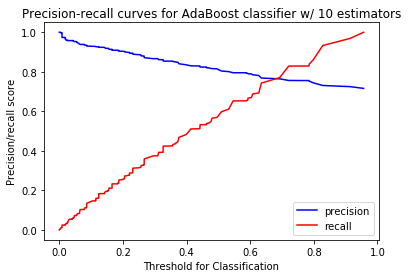

In [50]:
# Plot precision-recall curve for suggested model. Code adapted from Lab 4.

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_recall_curve

# Get 18-month training data
x_train, x_test, y_train, y_test = test_train[0]
x_train = x_train.drop(labels=['date_posted'], axis=1)
x_test = x_test.drop(labels=['date_posted'], axis=1)

# Train
boost = AdaBoostClassifier(n_estimators=10, random_state=0)
trained = boost.fit(x_train, y_train)
y_scores = boost.predict_proba(x_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=1)
population = [sum(y_scores > threshold)/len(y_scores) for threshold in thresholds]

# Plot
p, = plt.plot(population, precision[:-1], color='b')
r, = plt.plot(population, recall[:-1], color='r')
plt.title('Precision-recall curves for AdaBoost classifier w/ 10 estimators')
plt.xlabel('Threshold for Classification')
plt.ylabel('Precision/recall score')
plt.legend([p, r], ['precision', 'recall'])
plt.savefig('output/best_model_precision.png', format='png')

### 3.3 How do the results change over time?

For each classifier used, we trained models on training data over three different lengths: 6, 12, and 18 months prior to the 6 months of data used to test our models. For example, since we have data from Jan 1, 2012 to Dec 31, 2013, the longest training data used was from Jan 1, 2012 to June 30, 2013, with July 1, 2013 to Dec 1, 2013 forming the test set. 

In almost every case, models trained on 18 months of training data outperformed the other two variants. However, models trained on 6 months of training data outperformed those trained on 12 months of training data across almost every metric (accuracy, f1, precision at various thresholds). If looking only at the AUC-ROC - a measure of balance between true and false positive rates, called the area under the curve (AUC) for the receiver operating characteristics (ROC) curve - the expected order appears, where models trained on 18th months of data outperform those trained on 12 months of data, which themselves outperform those trained on 6 months of data.

### 3.4 What would be your recommendation to someone who's working on this model to identify 5% of posted projects to intervene with? Which model should they decide to go forward with and deploy?

As always, this depends on the specific intervention and its goal. Is it to maximize overall fundraising dollars? To maximize the number of projects that are successfuly funded? (Fortunately, since DonorsChoose stops fundraising for a project once the intended goal amount is met, these are functionally the same thing.)

But the question remains. Which 5% of projects do we want to intervene on? If selecting projects deemed *most* likely to be fully funded in 60 days, those would be the projects probably likely to be fully funded without intervention at all. In this case, DonorsChoose could use "exciting" projects like these as a source of marketing material, or target the donor pools to those projects for additional giving opportunities on other projects. If so, I would recommend using the **boosting ensemble model trained on 18 months of data**, which performed the best on precision at 5%. In other words, of the top 5% of projects it identified as likely to be fully funded in 60 days, 95% of them were actually so. 

If intervening on the 5% of projects *least* likely to be funded within 60 days, or perhaps projects that were unlikely to do so without a nudge or sorts, the potential intervention here could be additional fundraising support in the form of DonorsChoose staff coaching the teacher involved on how to better ask for donations from their networks. In this case, the metric of interest would be the precision at 50% (assuming projects that are 50% likely to be funded within 60 days are on that threshold), and the model that performs best on this metric is still the **boosting ensemble model trained on 18 months of data**.

Perhaps the metric we want to maximize is the number of students reached by the 5% of projects we will intervene on. The specific interventions here could be any of the actions already mentioned above. In this case, we would select the combination of projects where the *expected* number of students reached (calculated by the likelihood of being fully funded in 60 days, multiplied by the number of students reached by that project) is the largest possible. Without prior knowledge of how the number of students reached is distributed among projects, we would do best here to maximize overall precision. Fortunately, the model that does this is still the **boosting ensemble model trained on 18 months of data*.

There are other considerations that we have not explored here. The specific model we choose to inform our interventions can depend on a whole host of factors. Should projects in schools in low-income neighborhoods get priority? Should projects that ask for specific types of resources (e.g. stationery vs. computers) get priority? Should projects that are most cost-efficient, serving the largest number of children for the lowest per-child dollar amount, get priority? If we know more about the specific ways DonorsChoose might seek to use this model to identify projects, and the range of interventions available to them, we could provide more useful recommendations.